In [4]:
# Clone the ibm and tsfm
! git clone https://github.com/IBM/tsfm.git
# Change directory. Move inside the tsfm repo.
%cd tsfm
# Install the tsfm library and scikit-learn
! pip install ".[notebooks]" scikit-learn
%cd ../

fatal: destination path 'tsfm' already exists and is not an empty directory.
/home/wsuser/work/tsfm
Processing /home/wsuser/work/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tsfm_public: filename=tsfm_public-0.2.9-py3-none-any.whl size=2317360 sha256=8f5be2c3317df36d5bea7ead11fa1cdaa4d600212d5ce09b126d2b80b633a97b
  Stored in directory: /tmp/wsuser/pip-ephem-wheel-cache-xaenvvco/wheels/7e/f4/97/d20ca5bd694193823d3c5a98c81a76351b5a26d039df185d2d
Successfully built tsfm_public
  Attempting uninstall: tsfm_public
    Found existing installation: tsfm_public 0.2.9
    Uninstalling tsfm_public-0.2.9:
      Successfully uninstalled tsfm_public-0.2.9
/home/wsuser/work


In [7]:
!pip install Bottleneck==1.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: Bottleneck
    Found existing installation: Bottleneck 1.3.5
    Uninstalling Bottleneck-1.3.5:
      Successfully uninstalled Bottleneck-1.3.5


In [11]:
pwd

'/home/wsuser/work'

In [ ]:
cat pollution.csv

In [58]:
import os
import math
import tempfile
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# TSFM libraries
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

In [59]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='oXTalHLbbI8KI4SPddB-7OWGLqVB0CdJ9fQwomfiBTBA',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu-de.cloud-object-storage.appdomain.cloud')

bucket = 'qampawithragaccelerator-donotdelete-pr-5sto1uhftsgjmk'
object_key = 'pollution.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_1 = pd.read_csv(body)
df_1.head(10)



,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
5,6,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
6,7,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
7,8,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
8,9,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0
9,10,2010,1,1,9,NaN,-20,-8.0,1017.0,NW,27.28,0,0


In [49]:
pollution_data = df_1
#pollution_data = pd.read_csv(
 #   "pollution.csv"
#)

timestamp_column = "date"
target_columns = ["pm2.5"]
observable_columns = ["DEWP","TEMP","PRES", "Iws"]

pollution_data['date'] = pd.to_datetime(pollution_data[['year','month','day', 'hour']])

In [50]:
#deal with NA
pollution_data['pm2.5'] = pollution_data['pm2.5'].interpolate()

<Axes: xlabel='date'>

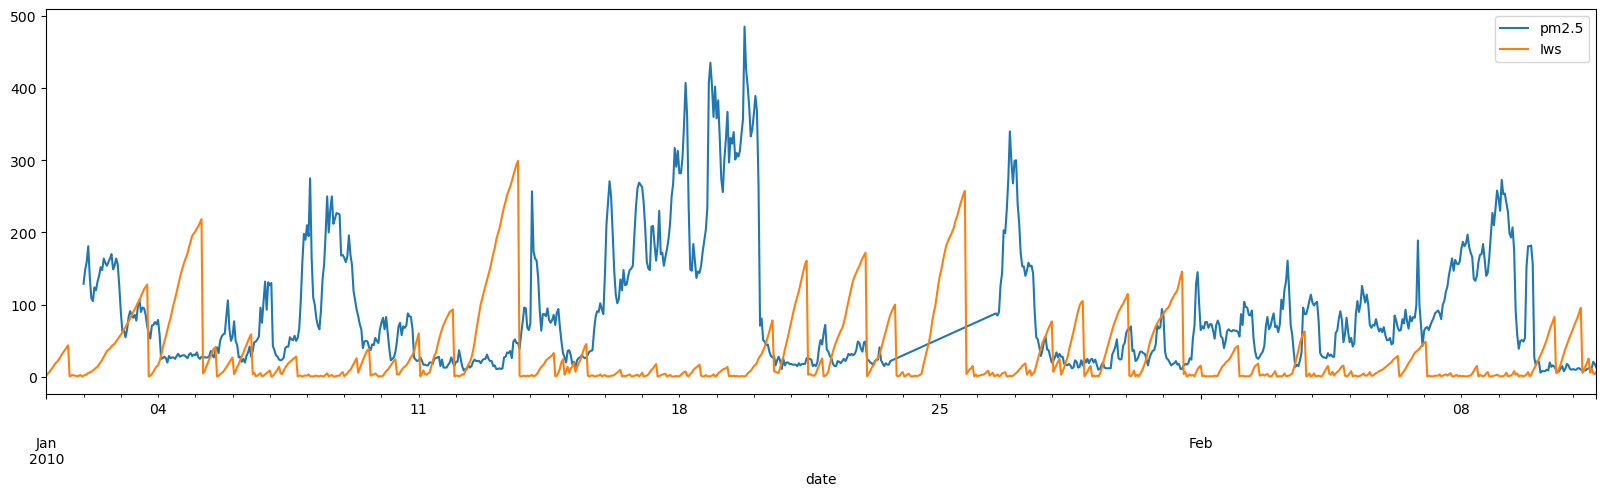

In [51]:
pollution_data[:1000].plot(x="date", y=["pm2.5", "Iws"], figsize=(20,5))

In [60]:
# Set seed for reproducibility
import tensorflow

SEED = 42
tensorflow.random.set_seed(SEED)
# Results dir
OUT_DIR = "/home/wsuser/work/ttm_finetuned_models/"

# Forecasting parameters
context_length = 512 # TTM can use 512 time points into the past
forecast_length = 96 # TTM can predict 96 time points into the future

In [61]:
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)

data_length = len(pollution_data)

train_start_index = 0
train_end_index = round(data_length * 0.8)

# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
eval_start_index = round(data_length * 0.8) - context_length
eval_end_index = round(data_length * 0.9)

test_start_index = round(data_length * 0.9) - context_length
test_end_index = data_length

split_config = {
                "train": [0, train_end_index],
                "valid": [eval_start_index, eval_end_index],
                "test": [test_start_index,test_end_index],
            }

In [62]:
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)

# this gets torch vectors for training. For test eval we need a Pandas DF
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, pollution_data, split_config
)

In [63]:
print (test_dataset)

In [65]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=24)
print(zeroshot_model)
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
)

zeroshot_trainer.evaluate(test_dataset)  #note that this is the Torch dataset created by get_datasets(), not a Pandas DataFrame

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

{'eval_loss': 0.298653781414032,
 'eval_model_preparation_time': 0.0019,
 'eval_runtime': 13.2407,
 'eval_samples_per_second': 362.443,
 'eval_steps_per_second': 45.315}

In [67]:
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)

# this gets torch vectors for training. For test eval we need a Pandas DF
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, pollution_data, split_config
)

In [68]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=24)

# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
)

zeroshot_trainer.evaluate(test_dataset)  #note that this is the Torch dataset created by get_datasets(), not a Pandas DataFrame

{'eval_loss': 0.298653781414032,
 'eval_model_preparation_time': 0.002,
 'eval_runtime': 13.289,
 'eval_samples_per_second': 361.125,
 'eval_steps_per_second': 45.15}

In [69]:
{'eval_loss': 0.425916463136673,
 'eval_runtime': 24.225,
 'eval_samples_per_second': 198.019,
 'eval_steps_per_second': 24.768}

{'eval_loss': 0.425916463136673,
 'eval_runtime': 24.225,
 'eval_samples_per_second': 198.019,
 'eval_steps_per_second': 24.768}

In [70]:
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

zs_forecast_pipeline = TimeSeriesForecastingPipeline(
    model=zeroshot_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    freq="1h"
)

In [71]:
zs_forecast = zs_forecast_pipeline(tsp.preprocess(pollution_data[test_start_index:test_end_index]))

<Axes: >

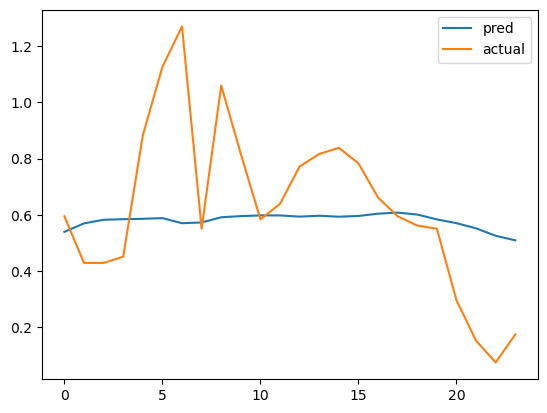

In [72]:
fcast_df = pd.DataFrame({"pred":zs_forecast.loc[50]['pm2.5_prediction'], "actual":zs_forecast.loc[50]['pm2.5'][:24]})
fcast_df.plot()

In [75]:
def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

In [78]:
import sklearn
one_day_out_predictions = compare_forecast(zs_forecast, "date", "pm2.5_prediction", "pm2.5", 12)
print(one_day_out_predictions)
rms = '{:.10f}'.format(sklearn.metrics.mean_squared_error(one_day_out_predictions['actual'], one_day_out_predictions['pred'], squared=False))
one_day_out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title=str(rms))

                    date    actual      pred
0    2014-07-02 09:00:00  0.173654 -0.403948
1    2014-07-02 10:00:00  0.029593 -0.473354
2    2014-07-02 11:00:00  0.140409 -0.432063
3    2014-07-02 12:00:00  0.129327 -0.414977
4    2014-07-02 13:00:00  0.395286 -0.320205
...                  ...       ...       ...
4378 2014-12-31 19:00:00       NaN -0.823805
4379 2014-12-31 20:00:00       NaN -0.858429
4380 2014-12-31 21:00:00       NaN -0.863322
4381 2014-12-31 22:00:00       NaN -0.892325
4382 2014-12-31 23:00:00       NaN -0.904466

[4383 rows x 3 columns]


ValueError: Input contains NaN.

In [80]:
# Important parameters
learning_rate = 0.001
num_epochs = 20
batch_size = 32

finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    #evaluation_strategy="epoch",
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

In [81]:
# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.001,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

NameError: name 'finetune_forecast_model' is not defined

In [82]:
finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

NameError: name 'finetune_forecast_model' is not defined

In [83]:
finetune_forecast_trainer.evaluate(test_dataset) #note that this is the torch dataset, not a Pandas DataFrame

NameError: name 'finetune_forecast_trainer' is not defined

In [84]:
forecast_pipeline = TimeSeriesForecastingPipeline(
    model=finetune_forecast_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    observable_columns=observable_columns,
    freq="1h"
)

forecasts = forecast_pipeline(test_data)

fcast_df = pd.DataFrame({"pred":forecasts.loc[50]['pm2.5_prediction'], "actual":forecasts.loc[50]['pm2.5'][:24]})
fcast_df.plot()

NameError: name 'finetune_forecast_model' is not defined

In [86]:
one_day_out_predictions = compare_forecast(forecasts, "date", "pm2.5_prediction", "pm2.5", 12)

rms = '{:.10f}'.format(mean_squared_error(one_day_out_predictions['actual'], one_day_out_predictions['pred'], squared=False))
one_day_out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="RMSE:" + str(rms))

NameError: name 'forecasts' is not defined